***Using Unsupervised learning for cluster count prediction and Outlier Detection***

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd


# Locate and load the data file
df = pd.read_csv('~/HW/HW8_YahyaAlSabeh/EP_dataset/clustering_synthetic_dataset.csv')

# Sanity check
print(f'N rows={len(df)}, M columns={len(df.columns)}')
df.columns

N rows=750, M columns=2


Index(['f1', 'f2'], dtype='object')

***How many species must be there in the dataset? (We will use this number as the number-of-clusters parameter in methods such as KMeans)*** 

If this was not readily apparent we would perform Elbow method, or analyze the Gap statistic.

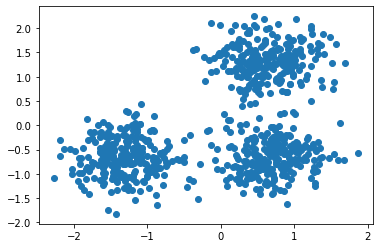

In [2]:
plt.scatter(x=df['f1'], y=df['f2'])

There should be just 3 clusters in this data, and this is readily apparent by plotting. In the NE, SE, SW quadrants.

***Let's find the rough feature ranges to classify these species correctly visually first***

Rough feature edges of 

species 1: Feature f2 in range of [0, -1.5], Feature f1 in range of [-2, 0.5]

species 2: Feature f2 in range of [0, -1.5], Feature f1 in range of [0, 1.3]

species 3: Feature f2 in range of [2, 0.5], Feature f1 in range of [0, 1.5]

***Now we will use K-means clustering to find anomalies.***

In [3]:
X = df.values
X

array([[ 0.49426097,  1.45106697],
       [-1.42808099, -0.83706377],
       [ 0.33855918,  1.03875871],
       ...,
       [-0.05713876, -0.90926105],
       [-1.16939407,  0.03959692],
       [ 0.26322951, -0.92649949]])

Inertia:  212.3913224947517


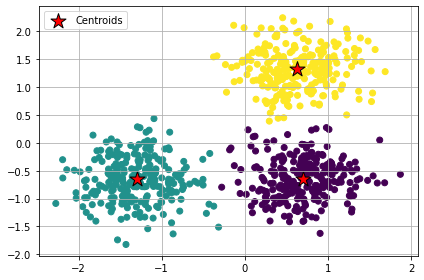

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score

def kmeans_k(_n_clusters, _X):
    km = KMeans(n_clusters=_n_clusters, init='random',
                n_init=10, max_iter=300, random_state=0)
    return km.fit_predict(_X), km.inertia_, km.cluster_centers_  #compute cluster centers and predict cluster index for each sample,
                                            #Also return the sum of squared distances of samples ot their cluster centers weighted by the sample weights.




y_pred, inertia, clusters = kmeans_k(3, X)
print('Inertia: ', inertia)
# Plot resulting clustering
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.scatter(clusters[:, 0], clusters[:, 1], s=250, marker= '*', c='red', edgecolor='black', label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

We will use a silhouette plot to look at outliers.

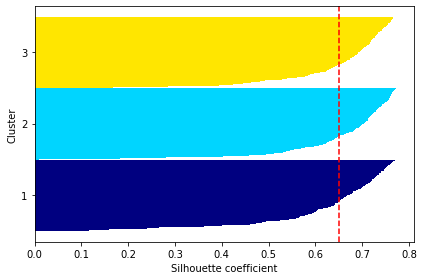

In [5]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_pred)
n_clusters = 3
silhouette_vals = silhouette_samples(X, y_pred, metric='euclidean')


y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_pred == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

[[-0.50601383 -0.29571545]
 [-0.16699918 -0.0916528 ]
 [ 0.46750573  0.45045933]
 [ 1.22425496  0.50161091]
 [-0.42227599 -0.19034456]
 [-0.46307453 -1.26531795]
 [ 0.85640775  0.25275335]
 [ 0.09982456  0.10950372]
 [ 0.80203144  0.22821584]
 [ 1.62198217  0.05020132]
 [-0.18357785 -0.12543358]
 [-0.12723135 -0.4090389 ]
 [-0.50267092 -0.75786841]
 [ 1.01170962  0.24102378]
 [-0.43185167 -1.10093485]
 [-0.3164503  -1.51218921]
 [ 0.29375547  0.38990412]
 [ 0.12203814  0.11914361]
 [-0.50375148 -0.65585405]
 [ 0.51340446  0.1488616 ]
 [ 0.9807011   0.27373202]
 [-0.2789764  -0.79571625]
 [ 0.40014881  0.44191365]
 [-0.37447929 -1.13624183]
 [ 0.03827028  0.23451742]
 [ 0.30603743  0.5363155 ]]


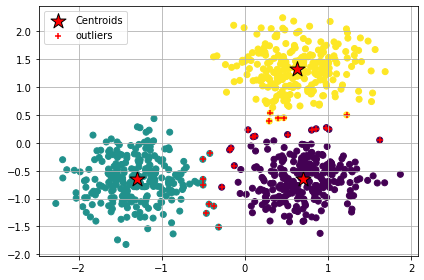

In [6]:
#Let's look at the points with a silhouette score less than 0.3
index_out = []
for i in range(len(silhouette_vals)):
    if (silhouette_vals[i] < 0.3):
        index_out.append(i)

print(X[index_out])
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.scatter(clusters[:, 0], clusters[:, 1], s=250, marker= '*', c='red', edgecolor='black', label='Centroids')
plt.scatter(X[index_out, 0], X[index_out, 1], marker = '+', c = 'red', label = 'outliers')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

Outliers are in red + sign as you can see, mainly dispersed in the in between regions of clsuters

***Now we will use DBSCAN clustering to find anomalies in the full dataset as an alternative to KMeans clustering. DBSCAN is a density based clustering algorithm rather than a Euclidean distance based clustering algorithm***

[14, 16, 18, 39, 76, 85, 95, 108, 110, 135, 146, 149, 156, 158, 165, 202, 215, 218, 259, 273, 282, 321, 337, 362, 387, 414, 443, 454, 461, 468, 531, 547, 570, 656, 657, 659, 663, 671, 679, 684]


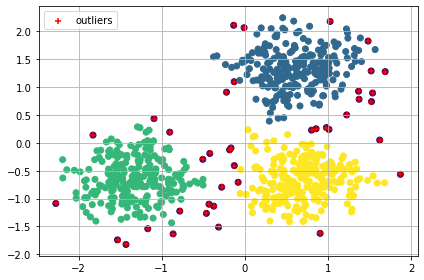

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np

def kmeans_k(_n_clusters, _X):
    km = KMeans(n_clusters=_n_clusters, init='random',
                n_init=10, max_iter=300, random_state=0)
    return km.fit_predict(_X), km.inertia_, km.cluster_centers_  #compute cluster centers and predict cluster index for each sample,
                                            #Also return the sum of squared distances of samples ot their cluster centers weighted by the sample weights.


db = DBSCAN(eps = 0.2, min_samples=5)
y_pred_db = db.fit_predict(X)

outlier_indices  = [index for (index, item) in enumerate(y_pred_db) if item == -1]
inlier_indices  = [index for (index, item) in enumerate(y_pred_db) if item != -1]
print(outlier_indices)

clusters = np.array(db.core_sample_indices_)

plt.scatter(X[:,0], X[:,1], c=y_pred_db)
plt.scatter(X[outlier_indices, 0], X[outlier_indices, 1], marker = '+', c = 'red', label = 'outliers')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

***Now, we will use the cleaned dataset develop a decision tree classifier to model the species, and we will visualize the model decision tree***

I will use the 2nd method, since it seems a bit more robust than the first.

In [8]:
X_cleaned = X[inlier_indices,:]
y_pred_cleaned = y_pred_db[inlier_indices]
print('y: ', len(y_pred_cleaned), 'X: ', len(X_cleaned))

y:  710 X:  710


In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')
    


Decision Tree CV accuracy=0.999 0.004


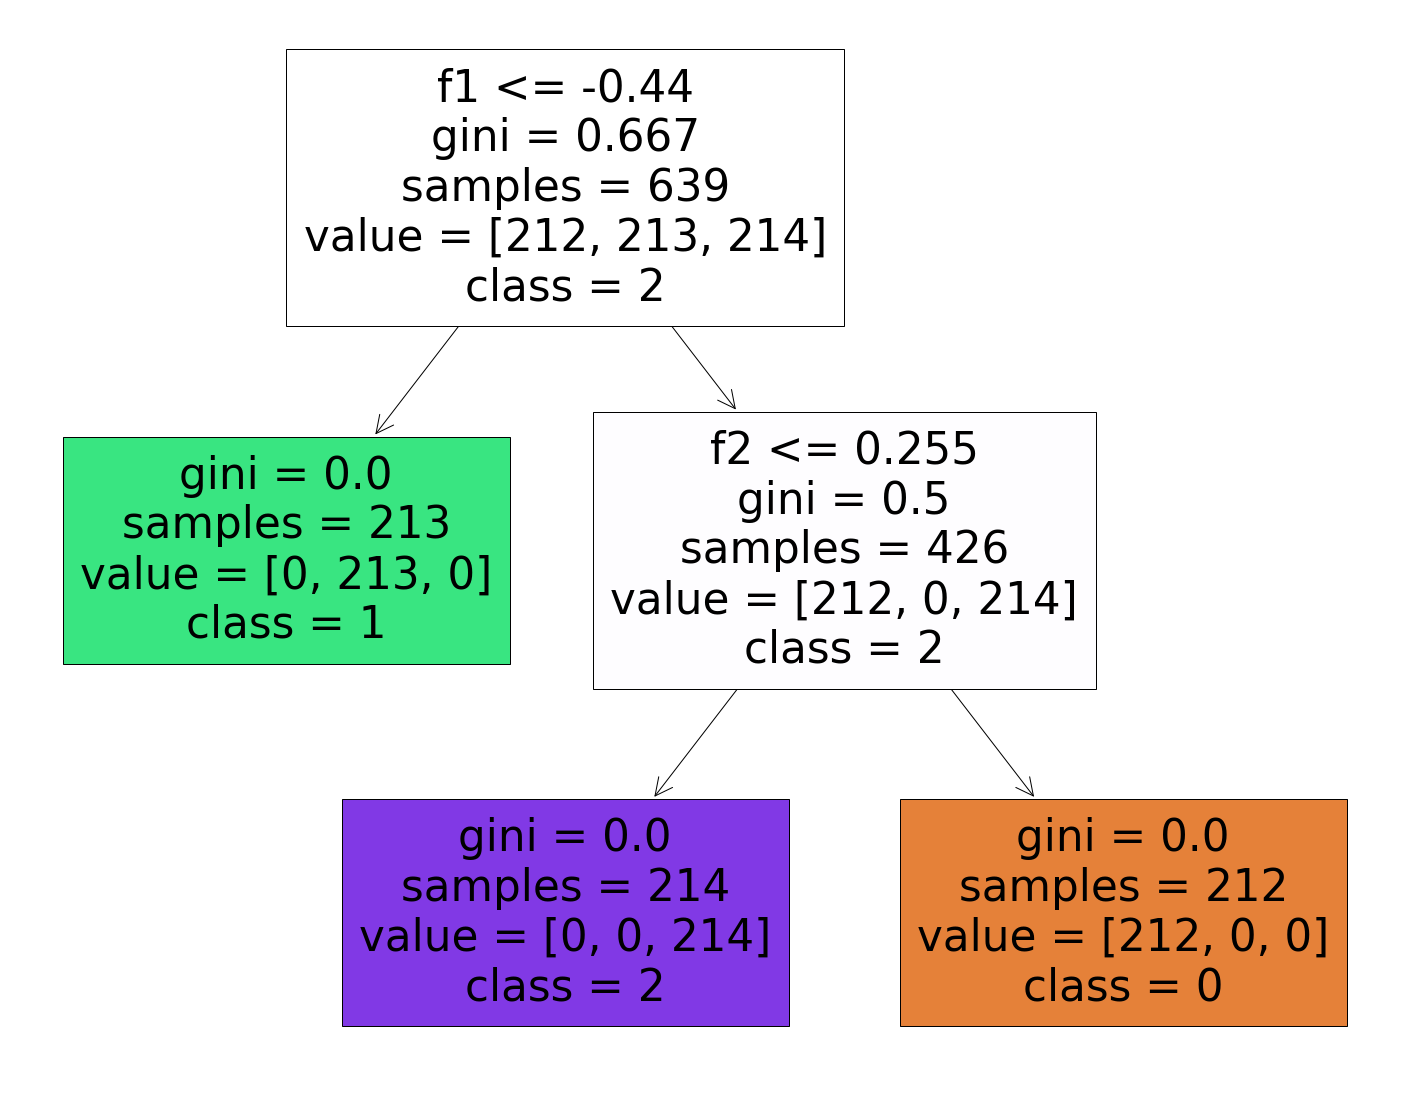

In [10]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree

def kfold_eval_docs(_clf, _X, _y):
    accs = []
    _niter = 10
    for i in range(_niter):
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
        for train_index, test_index in kf.split(_X, _y):
            _clf.fit(_X[train_index], _y[train_index])
            ypred = _clf.predict(_X[test_index])
            accs += [accuracy_score(_y[test_index], ypred)]

    return np.array(accs), _clf

dt = DecisionTreeClassifier(random_state=1)
acc, _clf = kfold_eval_docs(dt, X_cleaned, y_pred_cleaned)

text_representation = tree.export_text(_clf)
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)
    
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(_clf, feature_names=['f1','f2'],
                   class_names=['0','1','2'], filled=True)


print(f'Decision Tree CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

/tmp/ipykernel_5428/3728830468.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


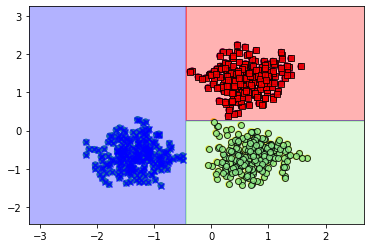

In [11]:
plt.scatter(X_cleaned[:,0], X_cleaned[:,1], c=y_pred_cleaned)
plot_decision_regions(X_cleaned,y_pred_cleaned, _clf)


***Did it, in fact, help to clean the outliers before generating the decision
tree.***

In the first division it correctly isolates cluster 1 as f1 that is less than -0.44, f1 here represents the X axis, this results in a pure child node. Then it subdivides the last two clusters as anything above f2 value of 0.255 where f2 is the y-axis, Anything above this is class 2 and anything below is class 0. Cleaning the outliers produced a vastly more simple to interpret decision tree, and a decision tree that is more reliable because it looks at less points close to the decision boundary.

***To demonstrate this point consider the same decision tree model with the unprocessed data***

Decision Tree CV accuracy=0.995 0.008


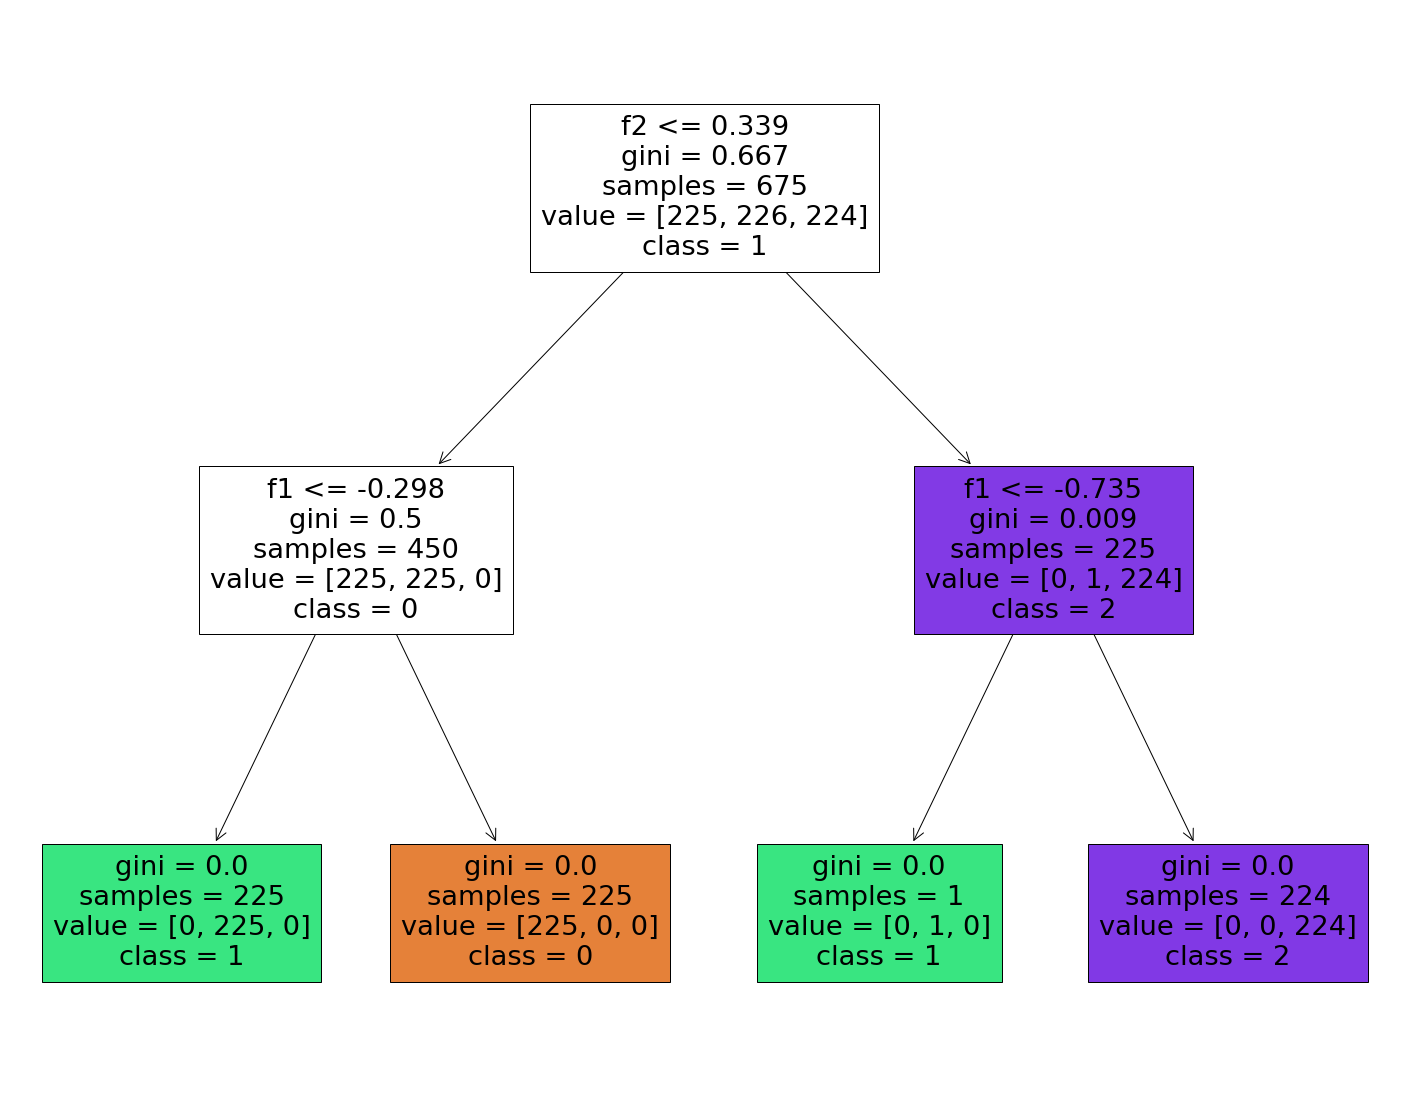

In [12]:
dt = DecisionTreeClassifier(random_state=1)
acc, _clf = kfold_eval_docs(dt, X, y_pred)

text_representation_2 = tree.export_text(_clf)
with open("decision_tree_uncleaned.log", "w") as fout:
    fout.write(text_representation_2)
    
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(_clf, feature_names=['f1','f2'],
                   class_names=['0','1','2'], filled=True)


print(f'Decision Tree CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

/tmp/ipykernel_5428/3728830468.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


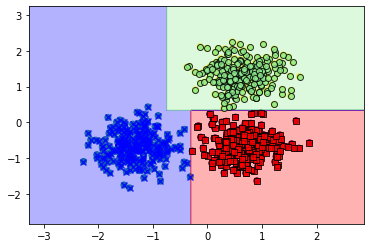

In [13]:
plt.scatter(X[:,0], X[:,1], c=y_pred)
plot_decision_regions(X,y_pred, _clf)
